Подключение библиотек и скриптов

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


In [2]:
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from datetime import datetime
import xgboost as xgb
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams.update({'font.size': 10})
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

Настройка отображения чисел

In [3]:
pd.options.display.float_format ='{:,.3f}'.format

Пути к файлам присваиваем переменным

In [4]:
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'

Загрузка данных для работы с ними

Описание датасета:

    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры

Исследование данных (EDA)

Запись данных в датафрейм train_df и просмотр данных при помощи метода describe

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.000,115.027,NaN,10.000,4,10.000,2014,0.075,B,B,11,3097,0,NaN,0,0,B,"305,018.871"
1,3013,22,1.000,39.833,23.169,8.000,7,8.000,1966,0.119,B,B,30,6207,1,"1,183.000",1,0,B,"177,734.553"
2,8215,1,3.000,78.342,47.672,10.000,2,17.000,1988,0.026,B,B,33,5261,0,240.000,3,1,B,"282,078.721"
3,2352,1,1.000,40.410,NaN,1.000,10,22.000,1977,0.007,B,B,1,264,0,NaN,0,1,B,"168,106.008"
4,13866,94,2.000,64.285,38.563,9.000,16,16.000,1972,0.283,B,B,33,8667,2,NaN,0,6,B,"343,995.103"


In [6]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,"10,000.000","10,000.000","10,000.000","10,000.000","7,887.000","10,000.000","10,000.000","10,000.000","10,000.000","10,000.000","10,000.000","10,000.000","10,000.000","5,202.000","10,000.000","10,000.000","10,000.000"
mean,"8,383.408",50.401,1.891,56.316,37.200,6.273,8.527,12.609,"3,990.166",0.119,24.687,"5,352.157",8.039,"1,142.904",1.319,4.231,"214,138.857"
std,"4,859.019",43.588,0.840,21.059,86.241,28.561,5.241,6.776,"200,500.261",0.119,17.533,"4,006.800",23.832,"1,021.517",1.494,4.806,"92,872.294"
min,0.000,0.000,0.000,1.137,0.371,0.000,1.000,0.000,"1,910.000",0.000,0.000,168.000,0.000,0.000,0.000,0.000,"59,174.778"
25%,"4,169.500",20.000,1.000,41.775,22.770,1.000,4.000,9.000,"1,974.000",0.018,6.000,"1,564.000",0.000,350.000,0.000,1.000,"153,872.634"
50%,"8,394.500",36.000,2.000,52.513,32.781,6.000,7.000,13.000,"1,977.000",0.075,25.000,"5,285.000",2.000,900.000,1.000,3.000,"192,269.645"
75%,"12,592.500",75.000,2.000,65.901,45.129,9.000,12.000,17.000,"2,001.000",0.196,36.000,"7,227.000",5.000,"1,548.000",2.000,6.000,"249,135.462"
max,"16,798.000",209.000,19.000,641.065,"7,480.592","2,014.000",42.000,117.000,"20,052,011.000",0.522,74.000,"19,083.000",141.000,"4,849.000",6.000,23.000,"633,233.467"


Выше видно, что датафрейм train_df содержит предположительно некорректные данные (например в колонках Rooms, Square, LifeSquare, KitchenSquare, HouseFloor, HouseYear), а так же в колонках LifeSquare, Healthcare_1 существуют пропуски данных.

Просмотр типов данных в датафрейме train_df

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Форматирование типов данных в датафрейме для снижения потребления памяти.
Ниже приведена функция для приведения типов данных к минимальнодоступным типам для хранения данных

In [8]:
def optimize_data(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')
        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    return df

In [9]:
optimize_data(train_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.000,115.027,NaN,10.000,4,10.000,2014,0.075,B,B,11,3097,0,NaN,0,0,B,"305,018.875"
1,3013,22,1.000,39.833,23.169,8.000,7,8.000,1966,0.119,B,B,30,6207,1,"1,183.000",1,0,B,"177,734.547"
2,8215,1,3.000,78.342,47.672,10.000,2,17.000,1988,0.026,B,B,33,5261,0,240.000,3,1,B,"282,078.719"
3,2352,1,1.000,40.410,NaN,1.000,10,22.000,1977,0.007,B,B,1,264,0,NaN,0,1,B,"168,106.000"
4,13866,94,2.000,64.285,38.563,9.000,16,16.000,1972,0.283,B,B,33,8667,2,NaN,0,6,B,"343,995.094"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.000,49.091,33.273,6.000,3,12.000,1981,0.300,B,B,52,10311,6,NaN,1,9,B,"119,367.453"
9996,16265,27,2.000,64.308,37.038,9.000,13,0.000,1977,0.072,B,B,2,629,1,NaN,0,0,A,"199,715.156"
9997,2795,178,1.000,29.648,16.555,5.000,3,5.000,1958,0.461,B,B,20,4386,14,NaN,1,5,B,"165,953.906"
9998,14561,21,1.000,32.330,22.327,5.000,3,9.000,1969,0.194,B,B,47,8004,3,125.000,3,5,B,"171,842.406"


Так как колонки 'Id' и 'DistrictId' не несут в себе никакой информации пригодной для математических вычислений, то приводим данные колонки к типу object.

In [10]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df['Rooms'] = train_df['Rooms'].astype('uint8')

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  object  
 1   DistrictId     10000 non-null  object  
 2   Rooms          10000 non-null  uint8   
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  uint8   
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  uint32  
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  uint8   
 13  Social_2       10000 non-null  uint16  
 14  Social_3       10000 non-null  uint8   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  uint8   
 17  Shops_1        10000 non-null  u

Как видно выше потребление памяти соркатилось более чем в два раза с 1,5 MB до 606 KB.

Далее посмотрим на целевую переменную. Целевой переменной в данном случае является 'Price'.
Для наглядности построим гистограмму распределения целевой переменной. 

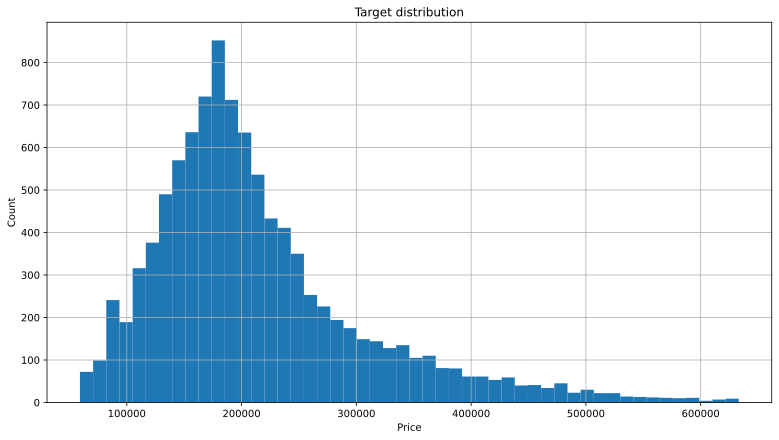

In [12]:
plt.figure(figsize = (13, 7))
train_df['Price'].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()

Целевая переменная распределена нормально.

In [13]:
train_df['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

Выше видно, что есть квартиры, в которых количество комнат более 5 штук, либо комнаты отсутствуют, что, возможно, является некорректным вводом данных.

In [14]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1

In [15]:
room_df = train_df[(train_df['Rooms'] >= 6) | (train_df['Rooms'] < 1)]
room_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
2004,5927,57,10,59.057,36.223,10.000,22,22.000,2002,0.091,...,B,74,19083,2,NaN,5,15,B,"317,265.312",1
2194,3159,88,0,38.697,19.345,9.000,9,16.000,1982,0.127,...,B,43,8429,3,NaN,3,9,B,"158,998.109",1
2728,14865,9,10,60.871,38.421,10.000,3,2.000,1994,0.162,...,B,25,5648,1,30.000,2,4,B,"172,329.266",1
3780,7317,27,0,41.791,NaN,0.000,13,0.000,1977,0.211,...,B,9,1892,0,NaN,0,1,B,"98,129.977",1
5894,770,28,0,49.484,NaN,0.000,16,0.000,2015,0.119,...,B,30,6207,1,"1,183.000",1,0,B,"217,009.344",1
6088,8491,1,19,42.006,21.779,7.000,17,17.000,2014,0.007,...,B,1,264,0,NaN,0,1,B,"78,364.617",1
6401,9443,27,0,87.763,85.125,0.000,5,15.000,1977,0.211,...,B,9,1892,0,NaN,0,1,B,"219,281.922",1
7644,7917,27,0,212.932,211.231,0.000,2,3.000,2008,0.211,...,B,9,1892,0,NaN,0,1,B,"302,211.250",1
7929,456,6,0,81.491,NaN,0.000,4,0.000,1977,0.243,...,B,5,1564,0,540.000,0,0,B,"212,864.797",1
8794,14003,99,6,59.414,38.702,6.000,7,9.000,1969,0.033,...,B,66,10573,1,"1,322.000",3,8,B,"229,661.969",1


Создание датафрейма содержащего сгруппированные данные по количеству комнат и медианной площади квартир.

In [16]:
rooms = pd.DataFrame(train_df.groupby('Rooms', as_index=False).agg({'Square': ['median']}))
rooms

,Rooms,Square
,,median
0,0,65.487
1,1,40.407
2,2,55.842
3,3,77.414
4,4,98.668
5,5,116.085
6,6,59.414
7,10,59.964
8,19,42.006


In [17]:
rooms = rooms.loc[(rooms['Rooms'] > 0) & (rooms['Rooms'] < 6)]
rooms

,Rooms,Square
,,median
1,1,40.407
2,2,55.842
3,3,77.414
4,4,98.668
5,5,116.085


Преобразование данных из датафрейма в list для последующей обработки.

In [18]:
list_room = rooms['Square']['median'].values.tolist()
list_room

[40.40658950805664,
 55.84181213378906,
 77.41364288330078,
 98.66806030273438,
 116.0848617553711]

Функция для определения количства комнат в квартирах, в которых указано значение комнат 0 или свыше 5

In [19]:
def find_rooms_count(a, df):
    for idx in df['Square'].values.tolist():
        res = min(enumerate(a), key=lambda x: abs(idx - x[1]))
        df.loc[df['Square'] == idx, 'Rooms'] = res[0] + 1
    return df

find_rooms_count(list_room, room_df)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
2004,5927,57,2,59.057,36.223,10.000,22,22.000,2002,0.091,...,B,74,19083,2,NaN,5,15,B,"317,265.312",1
2194,3159,88,1,38.697,19.345,9.000,9,16.000,1982,0.127,...,B,43,8429,3,NaN,3,9,B,"158,998.109",1
2728,14865,9,2,60.871,38.421,10.000,3,2.000,1994,0.162,...,B,25,5648,1,30.000,2,4,B,"172,329.266",1
3780,7317,27,1,41.791,NaN,0.000,13,0.000,1977,0.211,...,B,9,1892,0,NaN,0,1,B,"98,129.977",1
5894,770,28,2,49.484,NaN,0.000,16,0.000,2015,0.119,...,B,30,6207,1,"1,183.000",1,0,B,"217,009.344",1
6088,8491,1,1,42.006,21.779,7.000,17,17.000,2014,0.007,...,B,1,264,0,NaN,0,1,B,"78,364.617",1
6401,9443,27,3,87.763,85.125,0.000,5,15.000,1977,0.211,...,B,9,1892,0,NaN,0,1,B,"219,281.922",1
7644,7917,27,5,212.932,211.231,0.000,2,3.000,2008,0.211,...,B,9,1892,0,NaN,0,1,B,"302,211.250",1
7929,456,6,3,81.491,NaN,0.000,4,0.000,1977,0.243,...,B,5,1564,0,540.000,0,0,B,"212,864.797",1
8794,14003,99,2,59.414,38.702,6.000,7,9.000,1969,0.033,...,B,66,10573,1,"1,322.000",3,8,B,"229,661.969",1


Замена значений в первоначальном датафрейма на значения с исправленными значениями количества комнат

In [20]:
train_df.loc[(train_df['Rooms'] >= 6) | (train_df['Rooms'] < 1), 'Rooms'] = room_df
train_df['Rooms'].value_counts()

2    3884
1    3709
3    2237
4     150
5      20
Name: Rooms, dtype: int64

Таким образом были устранены выбросы по колонке 'Rooms'.

Обработка выбросов 'Square'

Для ознакомления с данными 'Square' построим гистограмму распределиния данного признака

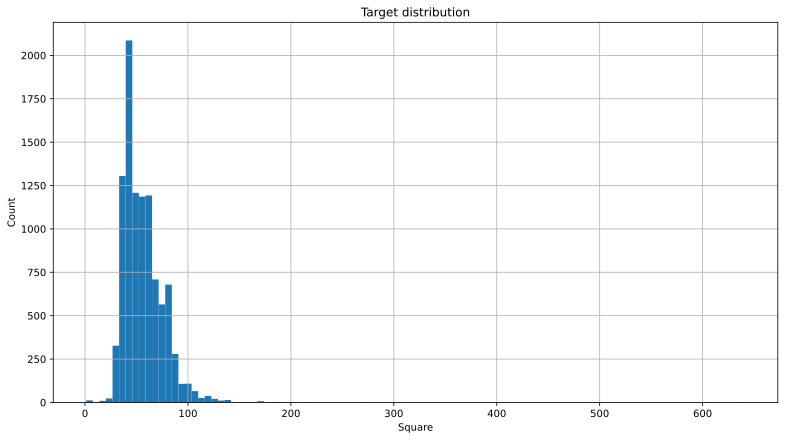

In [21]:
plt.figure(figsize = (13, 7))
train_df['Square'].hist(bins=100)
plt.ylabel('Count')
plt.xlabel('Square')
plt.title('Target distribution')
plt.show()

In [22]:
train_df.loc[train_df['LifeSquare'] < train_df['KitchenSquare'], ('LifeSquare', 'KitchenSquare')] = \
train_df.loc[train_df['LifeSquare'] < train_df['KitchenSquare'], ('KitchenSquare', 'LifeSquare')]

In [23]:
train_df.loc[train_df['Square'] < train_df['LifeSquare'], ('Square', 'LifeSquare')] = \
train_df.loc[train_df['Square'] < train_df['LifeSquare'], ('LifeSquare', 'Square')]
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare'] - 5

Обработка выбросов по площадям кухни.

In [24]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975)) \
            | (train_df['KitchenSquare'] > train_df['Square'])
        
train_df.loc[condition, 'KitchenSquare'] = train_df['Square'] / 10

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [25]:
train_df['KitchenSquare'].value_counts()

3.000     3183
8.000     1306
5.000     1169
10.000    1075
6.000     1038
          ... 
5.248        1
12.247       1
20.033       1
10.475       1
6.429        1
Name: KitchenSquare, Length: 200, dtype: int64

Обработка количества этажей в доме и этажа квартиры.

In [26]:
train_df.loc[train_df['HouseFloor'] > 100, 'HouseFloor'] = train_df['HouseFloor'] % 100
train_df['HouseFloor'].value_counts

<bound method IndexOpsMixin.value_counts of 0      10.000
1       8.000
2      17.000
3      22.000
4      16.000
        ...  
9995   12.000
9996    0.000
9997    5.000
9998    9.000
9999    9.000
Name: HouseFloor, Length: 10000, dtype: float32>

In [27]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'] = \
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor']

Обработка года постройки здания 'HouseYear'

In [28]:
date = datetime.now().year

In [29]:
train_df.loc[train_df['HouseYear'] > date, 'HouseYear'] = date

Обработка 'Healthcare_1'

In [30]:
train_df['Healthcare_1_nan'] = 0
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [31]:
class DataPreprocessing():
    
    
    def __init__(self):
        self.medians = None
        self.kitchen_max_square = None
        self.rooms = None
        self.rooms_filter = None
        self.list_room = None
        self.room_df = None
        self.date = None
    

    
    def fit(self, df):
        self.medians = df.median()
        self.kitchen_max_square = df['KitchenSquare'].quantile(0.975)
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('median').to_dict()
        self.room_df = df[(df['Rooms'] >= 6) | (df['Rooms'] < 1)]
        self.rooms = pd.DataFrame(df.groupby('Rooms', as_index=False).agg({'Square': ['median']}))
        self.rooms_filter = rooms.loc[(rooms['Rooms'] > 0) & (rooms['Rooms'] < 6)]
        self.date = datetime.now().year
        self.list_room = rooms['Square']['median'].values.tolist()
        
        def find_rooms_count(a, df):
            for idx in df['Square'].values.tolist():
                res = min(enumerate(a), key=lambda x: abs(idx - x[1]))
                df.loc[df['Square'] == idx, 'Rooms'] = res[0] + 1
            return df

        find_rooms_count(self.list_room, self.room_df)
    
    def transform(self, df):
        # замена квартир с выбрасами по комнатам на исправленные значения:
        df.loc[(df['Rooms'] >= 6) | (df['Rooms'] < 1), 'Rooms'] = self.room_df
        
        # Обработка выбросов по площадям кухни:
        condition = (df['KitchenSquare'].isna()) \
             | (df['KitchenSquare'] > df['KitchenSquare'].quantile(.975)) \
            | (df['KitchenSquare'] > df['Square'])
        
        df.loc[condition, 'KitchenSquare'] = df['Square'] / 10
        df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # Обработка выбросов по площадям
        df.loc[df['LifeSquare'] < df['KitchenSquare'], ('LifeSquare', 'KitchenSquare')] = \
        df.loc[df['LifeSquare'] < df['KitchenSquare'], ('KitchenSquare', 'LifeSquare')]
        df.loc[df['Square'] < df['LifeSquare'], ('Square', 'LifeSquare')] = \
        df.loc[df['Square'] < df['LifeSquare'], ('LifeSquare', 'Square')]
        df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df['Square'] - df['KitchenSquare'] - df['Square'] * 0.15
        df.loc[train_df['Square'] > train_df['Square'].quantile(.99), 'Square'] = df.loc[train_df['Square'] > train_df['Square'].quantile(.99), 'LifeSquare']
        
        # Обработка по этажности:
        df.loc[df['HouseFloor'] > 100, 'HouseFloor'] = df['HouseFloor'] % 100
        df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor']
        
        # Обработка возраста дома:
        train_df.loc[train_df['HouseYear'] > self.date, 'HouseYear'] = self.date
        
        # Обработка пропусков Healhcare_1:
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)
        
        # Замена категориальных переменных на бинарные:
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        # Удаление столбцов, не несущих в себе информации:
        df.drop('Id', axis=1, inplace=True)

        df.fillna(self.medians, inplace=True)
        return df

In [32]:
class FeatureGenetator():
    def __init__(self):
        self.districts_median_year = None
        self.district_price_per_square = None

        
    def fit(self, df): 
        # Группировка по району и среднему году постройки
        self.districts_median_year = df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict()
        # Группировка по району и средней цене за квадратный метр
        self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') \
        / df.groupby(['DistrictId'])['Square'].agg('median')  # median price for square meter in each district
    
    def new_features(self, df):
        # Создание нового признака со средним значением года постройки района      
        df['DistrictYear'] = df['DistrictId'].map(self.districts_median_year)
        
        self.median_district_year = df['DistrictYear'].median()
        df['DistrictYear'].fillna(self.median_district_year, inplace=True)

        # Создание нового признака со средней ценой квадратного метра в районе
        self.district_price_per_square.to_dict()
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price_per_square)
        
        self.median_district_price_per_square = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)


        # Создание признака по этажности
        floor_bins = [0, 3, 9, 15, df['Floor'].max()]
        df['Floor_category'] = pd.cut(df['Floor'], bins=floor_bins, labels=False)
        df['Floor_category'].fillna(-1, inplace=True) 
        
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=17)
        social_scaled = pd.DataFrame(scaler.fit_transform(df[['Social_1', 'Social_2', 'Social_3']]))
        df['Social'] = pca.fit_transform(social_scaled)
        ecology_scaled = pd.DataFrame(scaler.fit_transform(df[['Ecology_1', 'Ecology_2', 'Ecology_3']]))
        df['Ecology'] = pca.fit_transform(ecology_scaled)
        
        df.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1, inplace=True)
                
                
        return df

Разбиение датафрейма на train и test:

In [33]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)



In [34]:
preprocessor = DataPreprocessing()
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [35]:
features_gen = FeatureGenetator()
features_gen.fit(train_df)

train_df = features_gen.new_features(train_df)
test_df = features_gen.new_features(test_df)


In [36]:
y = pd.DataFrame(data=train_df['Price'])
train_df.drop('Price', axis=1, inplace=True)
X = train_df
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=17)

Построение модели GradientBoostingRegressor() для параметров min_samples_leaf и n_estimators использовался GridSearchCV()
Обучение модели

In [37]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=17,  
                                     n_estimators=1600, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.01
                                    )

gb_model.fit(X_train, y_train)



GradientBoostingRegressor(criterion='mse', learning_rate=0.01, loss='huber',
                          max_depth=6, max_features='sqrt', min_samples_leaf=50,
                          n_estimators=1600, random_state=17)

In [38]:
best_params = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])
best_params.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.287
16,DistrictPrice,0.184
1,Rooms,0.112
3,LifeSquare,0.074
10,Social_2,0.057
9,Social_1,0.051
18,Social,0.038
4,KitchenSquare,0.036
7,HouseYear,0.026
0,DistrictId,0.024


Оценка качества работы модели

In [39]:
y_train_pred = gb_model.predict(X_train)
y_test_pred = gb_model.predict(X_valid)
print(r2(y_train, y_train_pred))
print(r2(y_valid, y_test_pred))

0.8179672285117946
0.7668973769549087


запись результатов работы модели

In [40]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')

In [41]:
predictions = gb_model.predict(test_df)
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,"148,946.410"
1,5925,"120,973.268"
2,960,"143,197.556"
3,3848,"95,074.319"
4,746,"181,086.279"


In [42]:
submit.to_csv('VPonomarev_predict.csv', index=False)